## Import required packages

In [130]:
%load_ext autoreload
%autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [131]:
from IPython.core.debugger import set_trace
from io import StringIO
import numpy as np
import pandas as pd
import math
import missingno as msno
from sklearn.metrics import mean_squared_error
from scipy import stats
from sklearn.ensemble import IsolationForest
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()


## **Data Analysis**

In [132]:
trainDf = pd.read_csv('train.csv')
trainDf.replace("nan", np.nan, inplace=True)
trainDf.head(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [133]:
# we can drop the ID column
trainDf.drop(columns=['Id'], axis=1, inplace=True)

In [134]:
def dataset_datatypes_counts(data, col_sample_size):
    '''
    Identifies the Numerical, Categorial, Text, and Temporal(DateTime) features of the input dataframe.
    Considers the 
    Prints the different datatype columns along with a random sample values from each feature for a quick eyeball check of data
    This method is for just getting an understanding of different datatypes variables we have in the dataset. 
    Be cautious about the year feature
    '''
    # Caterogies mentioned as numerical values need to be considered as categories
    buf = StringIO()
    data.info(buf=buf)
    print(f"""\n:: dataset(DataFrame) Info ::\n\n{buf.getvalue()}""")

    string_vars_list = []
    categorical_vars_list = []
    numerical_vars_list = []

    numerical_vars_w_random_sample_list = []
    categorical_vars_w_random_sample_list = []
        
    for i in list(data.select_dtypes(include=[np.number, np.float64, np.float32]).columns):
#         if len(data[i].unique()) <= 5:
#             categorical_vars_list.append(i)
#             categorical_vars_w_random_sample_list.append(f"{i} - {data[i].dropna().sample(n=col_sample_size, replace=True, random_state=42).tolist()}")
#         else:
#             numerical_vars_list.append(i)
#             numerical_vars_w_random_sample_list.append(f"{i} - {data[i].sample(n=col_sample_size, replace=True, random_state=42).tolist()}")
#             #print(f"{i} - {data[i].sample(n=col_sample_size, random_state=42).tolist()}")
        numerical_vars_list.append(i)
        numerical_vars_w_random_sample_list.append(f"{i} - {data[i].sample(n=col_sample_size, replace=True, random_state=42).tolist()}")
        #print(f"{i} - {data[i].sample(n=col_sample_size, random_state=42).tolist()}")            
    
    
    for cat_name in list(data.select_dtypes(include=['category', 'object']).columns):
        if len(data[cat_name].unique()) > 50:
            string_vars_list.append(cat_name)
        else:
            categorical_vars_list.append(cat_name)
            categorical_vars_w_random_sample_list.append(f"{cat_name} - {data[cat_name].dropna().sample(n=col_sample_size, replace=True, random_state=42).tolist()}")
            # print(f"{cat_name} - {data[cat_name].dropna().sample(n=col_sample_size, replace=True, random_state=42).tolist()}")

    temporal_vars_list = list(data.select_dtypes(include=['datetime', 'datetime64', 'timedelta', 'timedelta64', 'datetimetz']).columns)

    print(f"\n:: numerical_features :: {len(numerical_vars_w_random_sample_list)}\n\n{chr(10).join(sorted(numerical_vars_w_random_sample_list))}\n""")
    print(f"\n:: categorical_features :: {len(categorical_vars_w_random_sample_list)}\n\n{chr(10).join(sorted(categorical_vars_w_random_sample_list))}\n")
    print(f"\n:: string/text_features :: {len(string_vars_list)}\n{string_vars_list}\n")
    print(f"\n:: temporal/datetime_features :: {len(temporal_vars_list)}\n{chr(10).join(sorted(temporal_vars_list))}\n")

    print(f"Dateframe Rows : {data.shape[0]}, Columns : {data.shape[1]}")
    print(f"Numerical({len(numerical_vars_w_random_sample_list)}) + Categorical({len(categorical_vars_w_random_sample_list)}) + Text({len(string_vars_list)}) + Temporal({len(temporal_vars_list)}) = {len(numerical_vars_w_random_sample_list)+len(categorical_vars_w_random_sample_list)+len(string_vars_list)+len(temporal_vars_list)}")
    
    return numerical_vars_list, categorical_vars_list, string_vars_list, temporal_vars_list

num_feat, cat_feat, text_feat, datetime_feat = dataset_datatypes_counts(data=trainDf, col_sample_size=10)


:: dataset(DataFrame) Info ::

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   Alley          91 non-null     object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 

As we are not going to create any new feature about the no. of houses sold between two time frames or years, we will consider the year feature as categorical. Below we change the datatype of year feature to object - YearBuilt, YearRemodAdd.
Similarly, Fireplaces, KitchenAbvGr, HalfBath, GarageCars, FullBath, BsmtHalfBath, BsmtFullBath need to be converted as numerical feature

In [135]:
def datatype_conversion(data, feat_list, conversion_type):
    if conversion_type == 'cat_to_num':
        for feat in feat_list:
            data[feat] = data[feat].astype('int',copy=False)
    
    if conversion_type == 'num_to_cat':
        for feat in feat_list:
            data[feat] = data[feat].astype('object',copy=False)
            
    return data

num_to_cat = ['YearBuilt', 'YearRemodAdd', 'YrSold', 'MoSold']
trainDf = datatype_conversion(data=trainDf, feat_list=num_to_cat, conversion_type='num_to_cat')

num_feat, cat_feat, text_feat, datetime_feat = dataset_datatypes_counts(data=trainDf, col_sample_size=10)


:: dataset(DataFrame) Info ::

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   Alley          91 non-null     object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 

In [136]:
# List the features having missing values
feat_w_missing_values_list = trainDf.columns[trainDf.isna().any()].tolist()

print(f"Features with missing values : {len(feat_w_missing_values_list)}\n\n{feat_w_missing_values_list}")

# percentage of missing values
total = trainDf.isnull().sum().sort_values(ascending=False)
percent = (trainDf.isnull().sum()/trainDf.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(25)

Features with missing values : 19

['LotFrontage', 'Alley', 'MasVnrType', 'MasVnrArea', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Electrical', 'FireplaceQu', 'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature']


,Total,Percent
PoolQC,1453,0.995205
MiscFeature,1406,0.963014
Alley,1369,0.937671
Fence,1179,0.807534
FireplaceQu,690,0.472603
LotFrontage,259,0.177397
GarageType,81,0.055479
GarageCond,81,0.055479
GarageFinish,81,0.055479
GarageQual,81,0.055479


#### **Correlation Matrix**

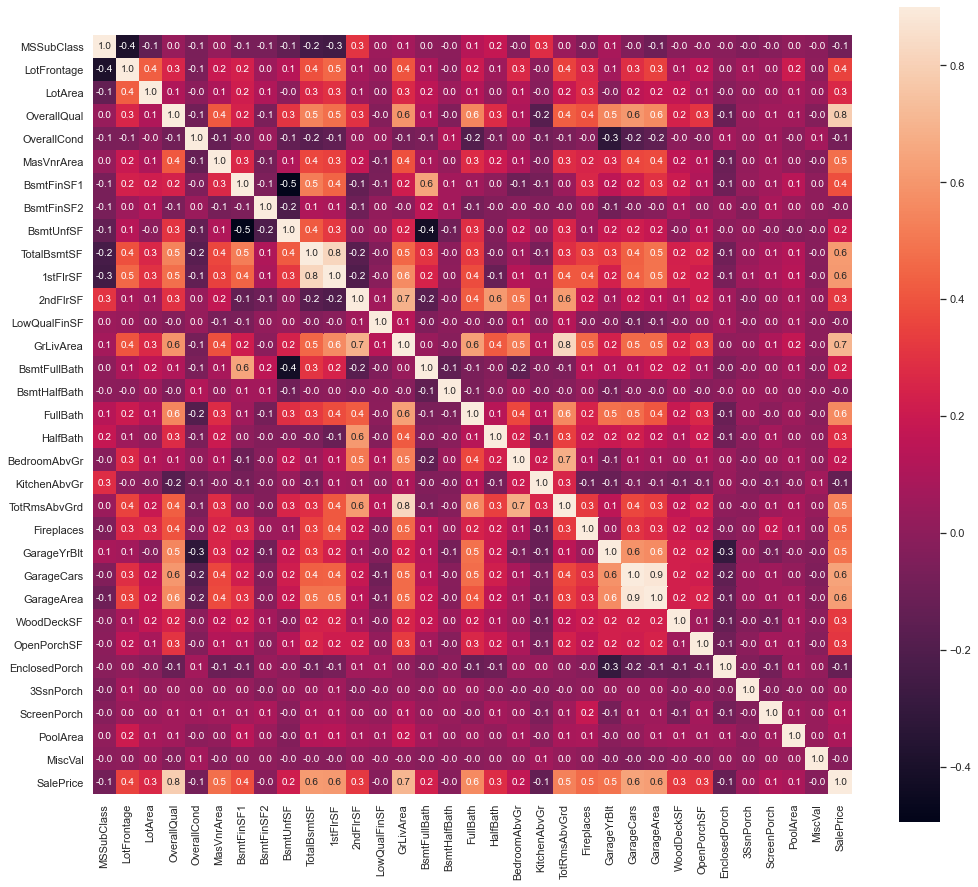

In [137]:
#correlation matrix
corrmat = trainDf.corr()
f, ax = plt.subplots(figsize=(17, 15))
#sns.set(font_scale=1.3)
sns.heatmap(corrmat, vmax=.9, annot=True, square=True, fmt='.1f', annot_kws={'size': 10});

### **Saleprice Correlation Matrix**

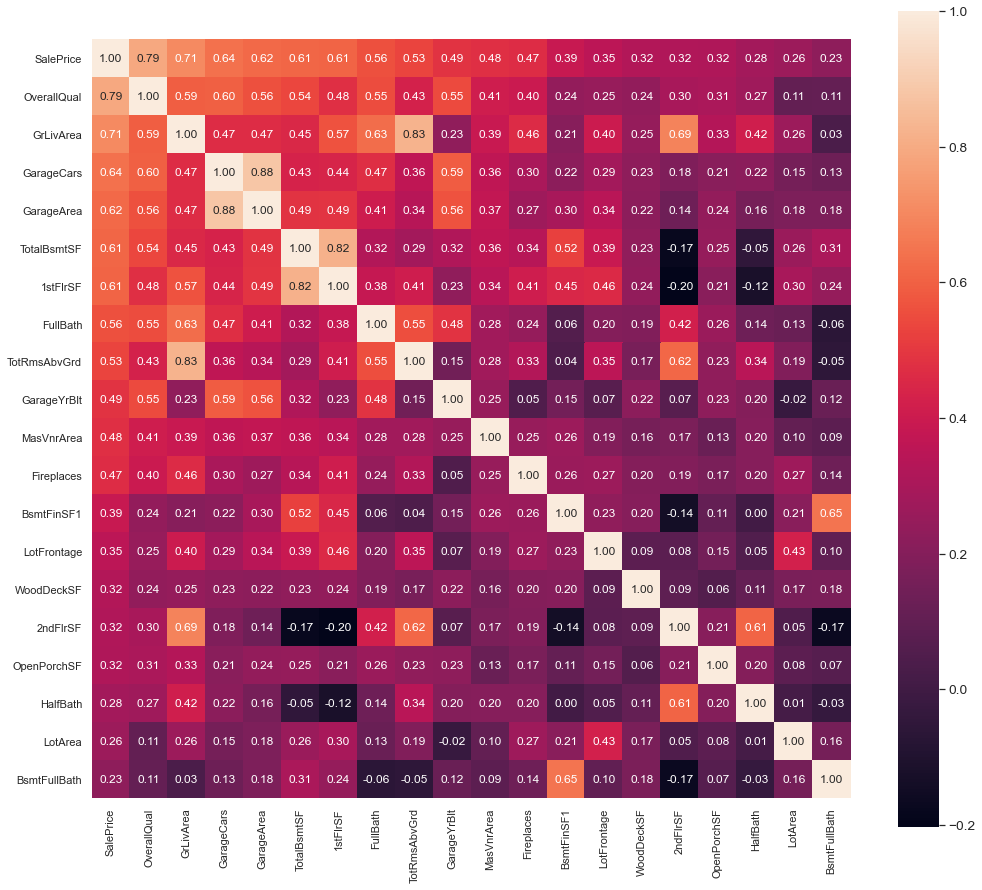

In [138]:
#saleprice correlation matrix
k = 20 #number of variables for heatmap
cols = corrmat.nlargest(k, 'SalePrice', keep='all')['SalePrice'].index
#cm = np.corrcoef(trainDf[cols].values.T)
#cm = np.corrcoef(trainDf[cols].values)
df = trainDf[cols]
corrmat = df.corr()
f, ax = plt.subplots(figsize=(17, 15))
# sns.heatmap(corrmat, vmax=.8, square=True);
sns.set(font_scale=1.25)
hm = sns.heatmap(corrmat, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 12}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

In [139]:
s = corrmat['SalePrice'].sort_values(ascending=False)
s

SalePrice       1.000000
OverallQual     0.790982
GrLivArea       0.708624
GarageCars      0.640409
GarageArea      0.623431
TotalBsmtSF     0.613581
1stFlrSF        0.605852
FullBath        0.560664
TotRmsAbvGrd    0.533723
GarageYrBlt     0.486362
MasVnrArea      0.477493
Fireplaces      0.466929
BsmtFinSF1      0.386420
LotFrontage     0.351799
WoodDeckSF      0.324413
2ndFlrSF        0.319334
OpenPorchSF     0.315856
HalfBath        0.284108
LotArea         0.263843
BsmtFullBath    0.227122
Name: SalePrice, dtype: float64

### Outliers check/drop in the highly correlated features
We consider the features which are highly correlated as the features with correlation value >= 0.5

In [140]:
highly_corr_feat = s[s>=0.5].index.tolist()
highly_corr_feat

['SalePrice',
 'OverallQual',
 'GrLivArea',
 'GarageCars',
 'GarageArea',
 'TotalBsmtSF',
 '1stFlrSF',
 'FullBath',
 'TotRmsAbvGrd']

### Drop the features which are less correlated to the target SalePrice

In [141]:
num_weak_corr_feat = ['GarageYrBlt', 'MasVnrArea', 'Fireplaces', 'BsmtFinSF1', 'LotFrontage', 'WoodDeckSF', 
                      '2ndFlrSF', 'OpenPorchSF', 'HalfBath', 'LotArea', 'BsmtFullBath']
trainDf = trainDf.drop(columns=num_weak_corr_feat, axis=1).reset_index(drop=True)


In [142]:
trainDf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 69 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   MSSubClass     1460 non-null   int64 
 1   MSZoning       1460 non-null   object
 2   Street         1460 non-null   object
 3   Alley          91 non-null     object
 4   LotShape       1460 non-null   object
 5   LandContour    1460 non-null   object
 6   Utilities      1460 non-null   object
 7   LotConfig      1460 non-null   object
 8   LandSlope      1460 non-null   object
 9   Neighborhood   1460 non-null   object
 10  Condition1     1460 non-null   object
 11  Condition2     1460 non-null   object
 12  BldgType       1460 non-null   object
 13  HouseStyle     1460 non-null   object
 14  OverallQual    1460 non-null   int64 
 15  OverallCond    1460 non-null   int64 
 16  YearBuilt      1460 non-null   object
 17  YearRemodAdd   1460 non-null   object
 18  RoofStyle      1460 non-null

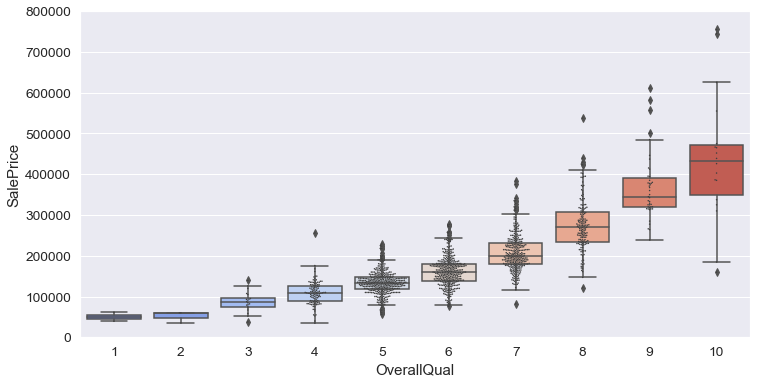

In [143]:
#box plot overallqual/saleprice
var = 'OverallQual'
data = pd.concat([trainDf['SalePrice'], trainDf[var]], axis=1)
f, ax = plt.subplots(figsize=(12, 6))
fig = sns.boxplot(x=var, y="SalePrice", data=data, palette="coolwarm")
fig = sns.swarmplot(x=var, y="SalePrice", data=data, color=".25", size=1.5)
fig.axis(ymin=0, ymax=800000);

In [144]:
# dropping outliers in the OverallQual feature
outliers_OverallQual_4 = trainDf.loc[(trainDf['OverallQual']==4) & (trainDf['SalePrice']>200000.0)]
outliers_OverallQual_8 = trainDf.loc[(trainDf['OverallQual']==8) & (trainDf['SalePrice']>500000.0)]
outliers_OverallQual_9 = trainDf.loc[(trainDf['OverallQual']==9) & (trainDf['SalePrice']>500000.0)]
outliers_OverallQual_10 = trainDf.loc[(trainDf['OverallQual']==10) & (trainDf['SalePrice']>700000.0)]
outliers_OverallQual = pd.concat([outliers_OverallQual_4, outliers_OverallQual_8, 
                                  outliers_OverallQual_9, outliers_OverallQual_10])
display(outliers_OverallQual[highly_corr_feat])
trainDf = trainDf.drop(outliers_OverallQual.index).reset_index(drop=True)

,SalePrice,OverallQual,GrLivArea,GarageCars,GarageArea,TotalBsmtSF,1stFlrSF,FullBath,TotRmsAbvGrd
457,256000,4,1663,2,529,1364,1663,1,6
769,538000,8,3279,3,841,1650,1690,3,12
178,501837,9,2234,3,1166,2216,2234,2,9
803,582933,9,2822,3,1020,1734,1734,3,12
898,611657,9,2364,3,820,2330,2364,2,11
1046,556581,9,2868,3,716,1992,1992,3,11
691,755000,10,4316,3,832,2444,2444,3,10
1182,745000,10,4476,3,813,2396,2411,3,10


<AxesSubplot:xlabel='GrLivArea', ylabel='SalePrice'>

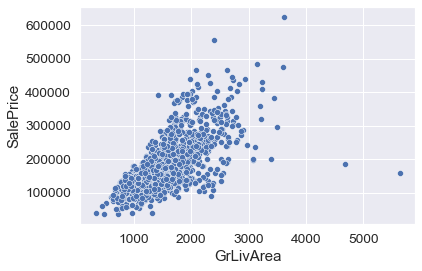

In [145]:
#box plot overallqual/saleprice
# var = 'GrLivArea'
# data = pd.concat([trainDf['SalePrice'], trainDf[var]], axis=1)
# f, ax = plt.subplots(figsize=(12, 6))
# fig = sns.boxplot(x=var, y="SalePrice", data=data, palette="coolwarm")
# fig = sns.swarmplot(x=var, y="SalePrice", data=data, color=".25", size=1.5)
# fig.axis(ymin=0, ymax=800000);

sns.scatterplot(data=trainDf, x="GrLivArea", y="SalePrice")

In [146]:
# dropping outliers in the GrLivArea feature which are above 4000 GrLivArea on x-axis

outliers_GrLivArea = trainDf.loc[(trainDf['GrLivArea']>4000)]

display(outliers_GrLivArea[highly_corr_feat])
trainDf = trainDf.drop(outliers_GrLivArea.index).reset_index(drop=True)

,SalePrice,OverallQual,GrLivArea,GarageCars,GarageArea,TotalBsmtSF,1stFlrSF,FullBath,TotRmsAbvGrd
521,184750,10,4676,3,884,3138,3138,3,11
1290,160000,10,5642,2,1418,6110,4692,2,12


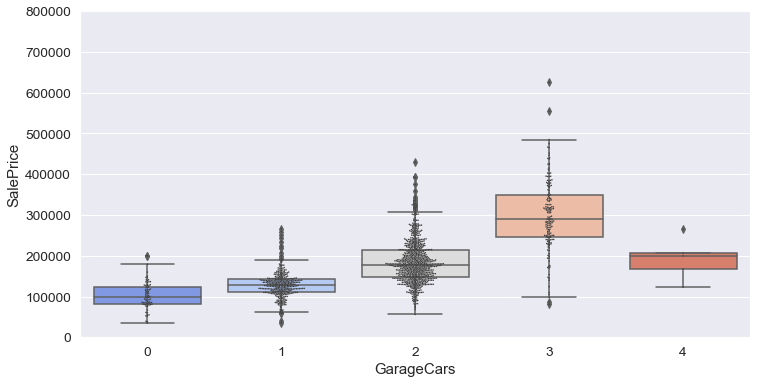

In [147]:
#box plot GarageCars/saleprice
var = 'GarageCars'
data = pd.concat([trainDf['SalePrice'], trainDf[var]], axis=1)
f, ax = plt.subplots(figsize=(12, 6))
fig = sns.boxplot(x=var, y="SalePrice", data=data, palette="coolwarm")
fig = sns.swarmplot(x=var, y="SalePrice", data=data, color=".25", size=1.5)
fig.axis(ymin=0, ymax=800000);

In [148]:
# dropping outliers in the GarageCars feature
outliers_GarageCars_3 = trainDf.loc[(trainDf['GarageCars']==3) & (trainDf['SalePrice']>500000.0)]
outliers_GarageCars_2 = trainDf.loc[(trainDf['GarageCars']==2) & (trainDf['SalePrice']>400000.0)]

outliers_GarageCars = pd.concat([outliers_GarageCars_3, outliers_GarageCars_2])
display(outliers_GarageCars[highly_corr_feat])
trainDf = trainDf.drop(outliers_GarageCars.index).reset_index(drop=True)
trainDf.info()

,SalePrice,OverallQual,GrLivArea,GarageCars,GarageArea,TotalBsmtSF,1stFlrSF,FullBath,TotRmsAbvGrd
439,555000,10,2402,3,672,3094,2402,2,10
1161,625000,10,3627,3,807,1930,1831,3,10
494,430000,8,3228,2,546,3200,3228,3,10


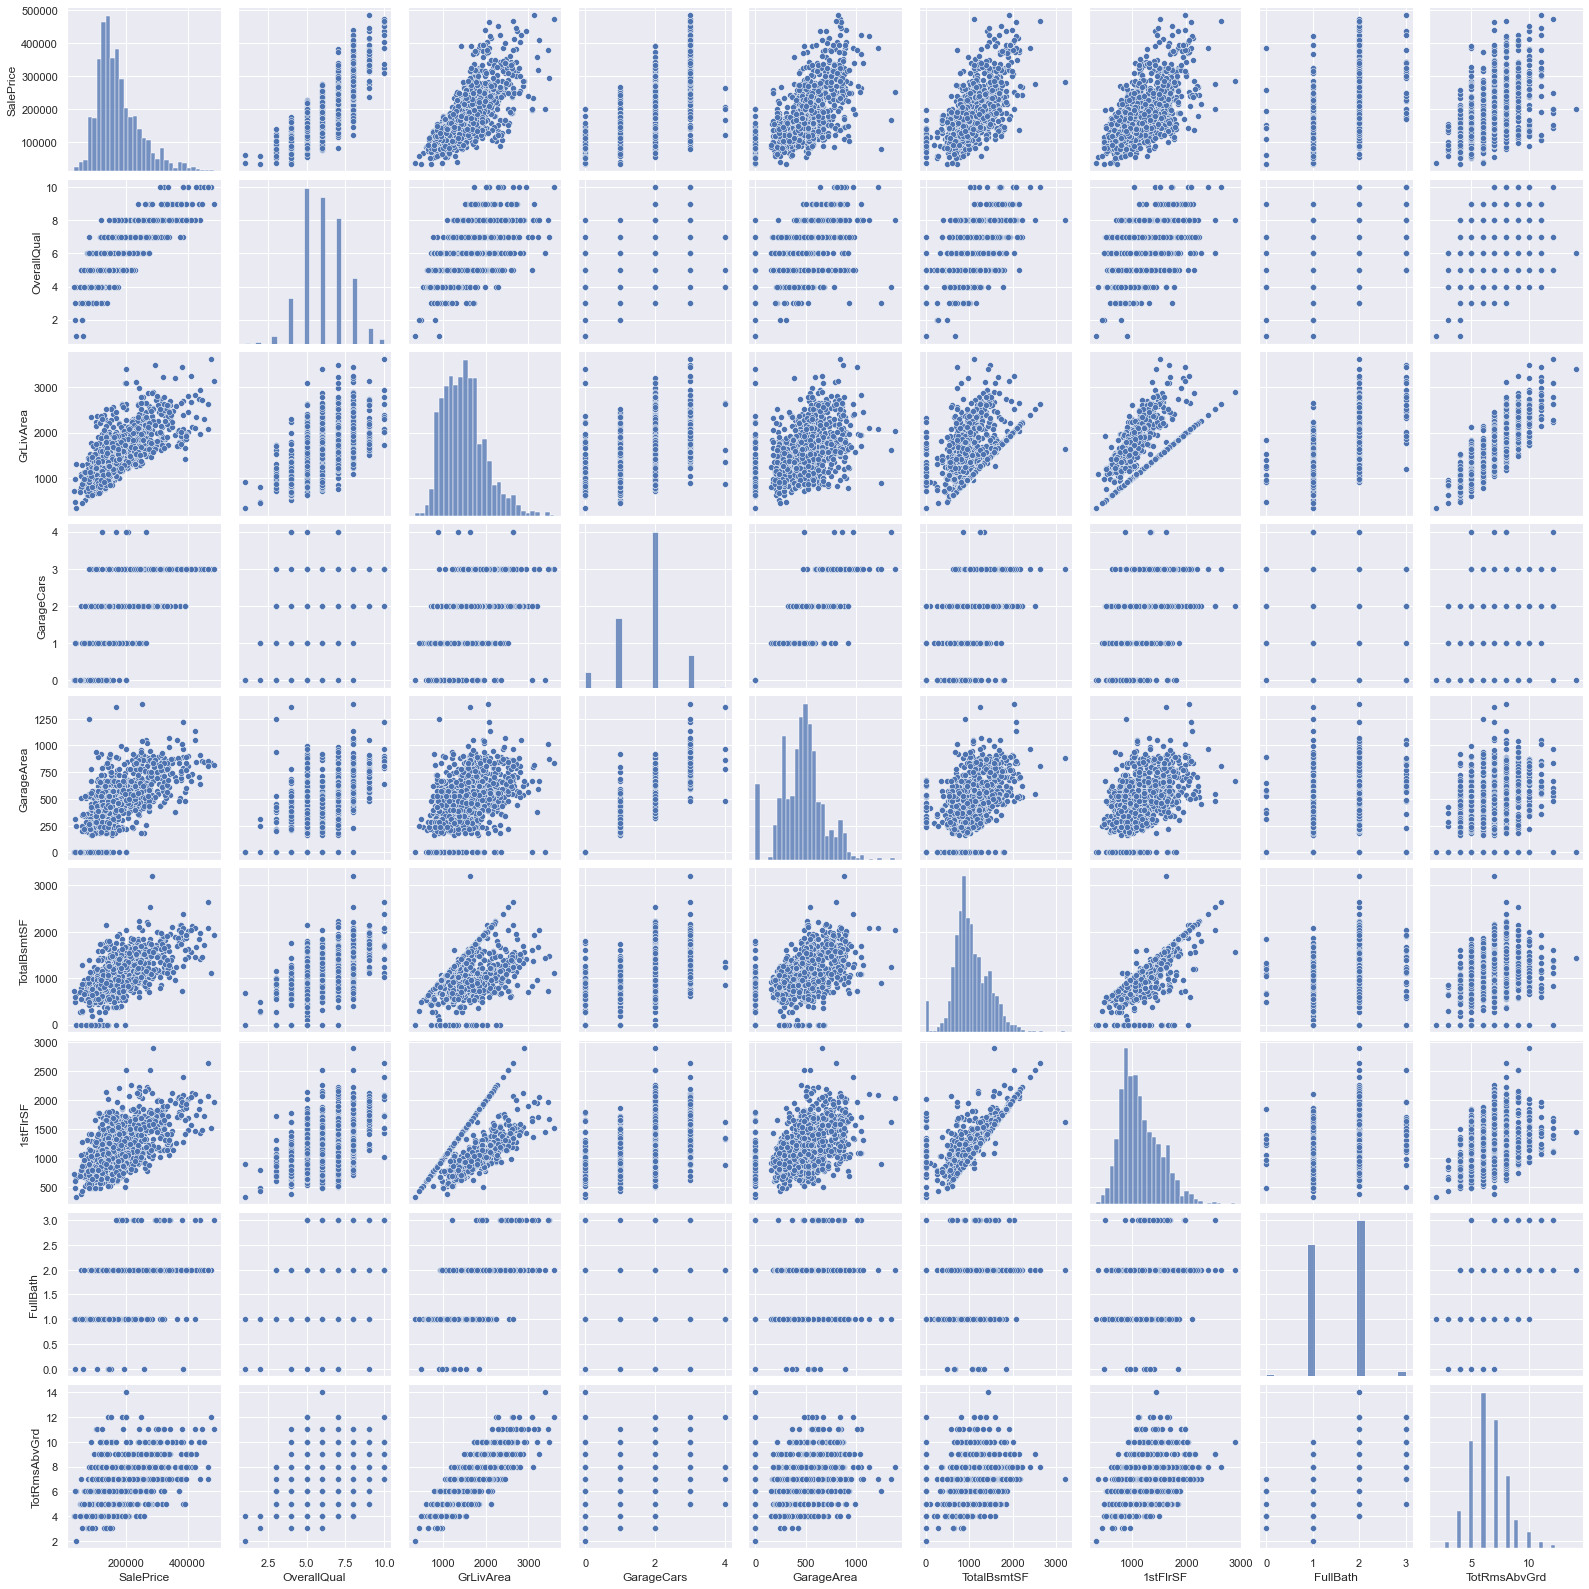

In [17]:
#scatterplot
sns.set()
cols = ['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'GarageArea', 'TotalBsmtSF', '1stFlrSF', 'FullBath', 'TotRmsAbvGrd']
sns.pairplot(trainDf[cols], height = 2.5)
plt.show();

D:\SoftwareInstallation\Anaconda\envs\VirtualEnv\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
D:\SoftwareInstallation\Anaconda\envs\VirtualEnv\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
D:\SoftwareInstallation\Anaconda\envs\VirtualEnv\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result i

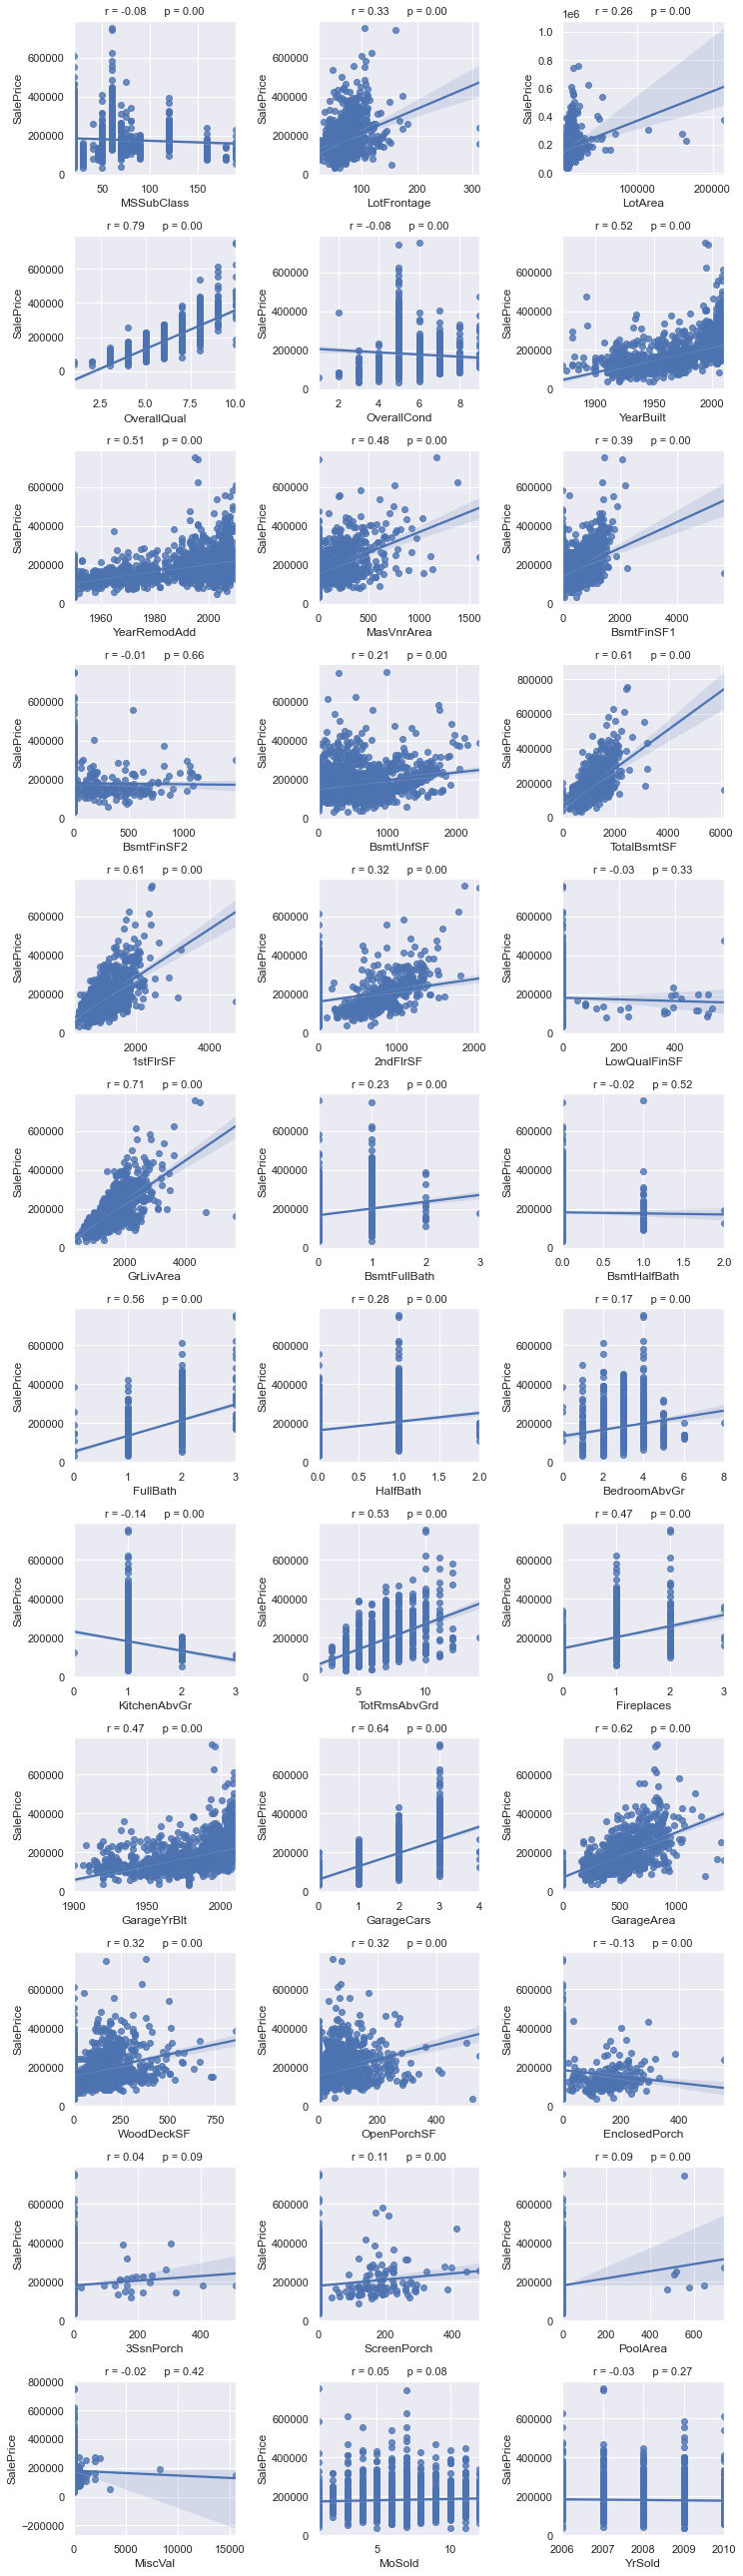

In [123]:
df_train = trainDf.copy()
df_train.fillna(df_train.mean(), inplace=True)
#df_test.fillna(df_test.mean(), inplace=True)
numerical_feats = df_train.dtypes[df_train.dtypes != "object"].index
target = 'SalePrice'

nr_rows = 12
nr_cols = 3

fig, axs = plt.subplots(nr_rows, nr_cols, figsize=(nr_cols*3.5,nr_rows*3))

li_num_feats = list(numerical_feats)
li_not_plot = ['Id', 'SalePrice', 'SalePrice_Log']
li_plot_num_feats = [c for c in list(numerical_feats) if c not in li_not_plot]

for r in range(0, nr_rows):
    for c in range(0,nr_cols):  
        i = r*nr_cols+c
        if i < len(li_plot_num_feats):
            sns.regplot(df_train[li_plot_num_feats[i]], df_train[target], ax = axs[r][c])
            stp = stats.pearsonr(df_train[li_plot_num_feats[i]], df_train[target])
            #axs[r][c].text(0.4,0.9,"title",fontsize=7)
            str_title = "r = " + "{0:.2f}".format(stp[0]) + "      " "p = " + "{0:.2f}".format(stp[1])
            axs[r][c].set_title(str_title,fontsize=11)
            
plt.tight_layout()    
plt.show() 

In [122]:
corrmat['SalePrice'].sort_values(ascending=False).abs()

SalePrice       1.000000
OverallQual     0.790982
GrLivArea       0.708624
GarageCars      0.640409
GarageArea      0.623431
TotalBsmtSF     0.613581
1stFlrSF        0.605852
FullBath        0.560664
TotRmsAbvGrd    0.533723
GarageYrBlt     0.486362
MasVnrArea      0.477493
Fireplaces      0.466929
BsmtFinSF1      0.386420
LotFrontage     0.351799
WoodDeckSF      0.324413
2ndFlrSF        0.319334
OpenPorchSF     0.315856
HalfBath        0.284108
LotArea         0.263843
BsmtFullBath    0.227122
Name: SalePrice, dtype: float64

In [150]:
trainDf.describe()

,MSSubClass,OverallQual,OverallCond,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,LowQualFinSF,GrLivArea,BsmtHalfBath,...,KitchenAbvGr,TotRmsAbvGrd,GarageCars,GarageArea,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,SalePrice
count,1447.000000,1447.000000,1447.000000,1447.000000,1447.000000,1447.000000,1447.000000,1447.000000,1447.000000,1447.000000,...,1447.000000,1447.000000,1447.000000,1447.000000,1447.000000,1447.000000,1447.000000,1447.000000,1447.000000,1447.000000
mean,57.007602,6.073946,5.579129,46.595024,565.180373,1043.710435,1151.079475,5.897028,1498.949551,0.057360,...,1.046994,6.483760,1.758120,469.583276,21.950242,3.440221,14.800968,2.068417,43.879751,178053.343469
std,42.434091,1.354539,1.116545,161.468813,439.464082,401.174820,360.491153,48.837989,486.875893,0.238482,...,0.221282,1.585587,0.743502,210.573333,60.951415,29.447031,55.413626,35.493344,498.330973,71654.181870
min,20.000000,1.000000,1.000000,0.000000,0.000000,0.000000,334.000000,0.000000,334.000000,0.000000,...,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,34900.000000
25%,20.000000,5.000000,5.000000,0.000000,220.500000,794.000000,881.000000,0.000000,1127.000000,0.000000,...,1.000000,5.000000,1.000000,326.500000,0.000000,0.000000,0.000000,0.000000,0.000000,129900.000000
50%,50.000000,6.000000,5.000000,0.000000,476.000000,990.000000,1082.000000,0.000000,1456.000000,0.000000,...,1.000000,6.000000,2.000000,478.000000,0.000000,0.000000,0.000000,0.000000,0.000000,162000.000000
75%,70.000000,7.000000,6.000000,0.000000,807.000000,1279.500000,1379.500000,0.000000,1768.000000,0.000000,...,1.000000,7.000000,2.000000,576.000000,0.000000,0.000000,0.000000,0.000000,0.000000,213000.000000
max,190.000000,10.000000,9.000000,1474.000000,2336.000000,3206.000000,2898.000000,572.000000,3608.000000,2.000000,...,3.000000,14.000000,4.000000,1390.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,485000.000000


Foundation
PConc         635
CBlock        633
BrkTil        146
Slab           24
Stone           6
Wood            3
dtype: int64

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1447 entries, 0 to 1446
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Foundation  1447 non-null   object
dtypes: object(1)
memory usage: 11.4+ KB


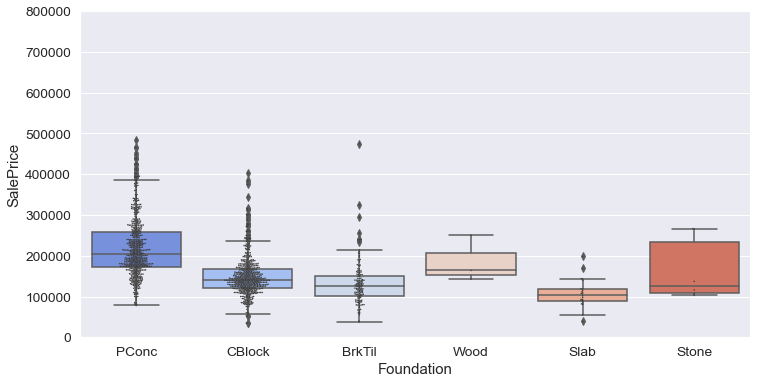

In [151]:
#box plot MoSold/saleprice
var = 'Foundation'
data = pd.concat([trainDf['SalePrice'], trainDf[var]], axis=1)
f, ax = plt.subplots(figsize=(12, 6))
fig = sns.boxplot(x=var, y="SalePrice", data=data, palette="coolwarm")
fig = sns.swarmplot(x=var, y="SalePrice", data=data, color=".25", size=1.5)
fig.axis(ymin=0, ymax=800000);

display(trainDf[[var]].value_counts())
trainDf[[var]].info()

In [30]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

lm = ols('SalePrice~RoofMatl', data=trainDf).fit()
dir(lm)
table = sm.stats.anova_lm(lm)
table

,df,sum_sq,mean_sq,F,PR(>F)
RoofMatl,6.0,1.234876e+11,2.058126e+10,4.059453,0.000483
Residual,1440.0,7.300742e+12,5.069960e+09,NaN,NaN


In [76]:
trainDf[trainDf['OverallQual'] == 10]['OverallQual']

clf = IsolationForest(n_estimators=100, contamination=0.5, max_samples='auto', random_state=42)
clf.fit(np.array(trainDf[trainDf['OverallQual'] == 10]['OverallQual']).reshape(-1, 1))
df['OverallQual'] = trainDf[['OverallQual']]
df['scores']=clf.decision_function(trainDf[['OverallQual']])
df['anomaly']=clf.predict(trainDf[['OverallQual']])
df


<ipython-input-76-248b3a0ae8aa>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['OverallQual'] = trainDf[['OverallQual']]


ValueError: Length of values (1447) does not match length of index (1460)

In [126]:
cat_feat

['MSZoning',
 'Street',
 'Alley',
 'LotShape',
 'LandContour',
 'Utilities',
 'LotConfig',
 'LandSlope',
 'Neighborhood',
 'Condition1',
 'Condition2',
 'BldgType',
 'HouseStyle',
 'RoofStyle',
 'RoofMatl',
 'Exterior1st',
 'Exterior2nd',
 'MasVnrType',
 'ExterQual',
 'ExterCond',
 'Foundation',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'Heating',
 'HeatingQC',
 'CentralAir',
 'Electrical',
 'KitchenQual',
 'Functional',
 'FireplaceQu',
 'GarageType',
 'GarageFinish',
 'GarageQual',
 'GarageCond',
 'PavedDrive',
 'PoolQC',
 'Fence',
 'MiscFeature',
 'MoSold',
 'YrSold',
 'SaleType',
 'SaleCondition']

In [152]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

target_feat = 'SalePrice'
cat_features = cat_feat

def anova_test(df, target_feat, cat_features):    
    aov_df = pd.DataFrame({'df': pd.Series([], dtype='float'),
                   'sum_sq': pd.Series([], dtype='float'),
                   'mean_sq': pd.Series([], dtype='float'),
                   'F': pd.Series([], dtype='float'),
                   'PR(>F)': pd.Series([], dtype='float'),})
    
    for feat in cat_features:
        #set_trace()
        feat_corr = f"{target_feat}~{feat}"
        lm = ols(feat_corr, data=df).fit()
        table = sm.stats.anova_lm(lm)        
        aov_df = aov_df.append(table.iloc[0],ignore_index=False)
        #set_trace()
    aov_df.sort_values(by=['PR(>F)'], inplace=True)
    return aov_df

aov_df = anova_test(df=trainDf, target_feat=target_feat, cat_features=cat_features)
aov_df

,df,sum_sq,mean_sq,F,PR(>F)
Neighborhood,24.0,4.115933e+12,1.714972e+11,73.714375,2.526622e-229
ExterQual,3.0,3.627686e+12,1.209229e+12,459.606874,1.514593e-209
KitchenQual,3.0,3.408018e+12,1.136006e+12,408.159928,6.191067e-192
BsmtQual,3.0,3.279229e+12,1.093076e+12,392.547929,3.467847e-185
GarageFinish,2.0,1.948031e+12,9.740156e+11,270.339484,1.305603e-99
Foundation,5.0,2.036609e+12,4.073217e+11,108.944304,9.793712e-98
GarageType,5.0,1.546861e+12,3.093721e+11,79.207142,4.821590e-73
HeatingQC,4.0,1.540028e+12,3.850070e+11,94.350983,2.414112e-71
MasVnrType,3.0,1.430846e+12,4.769485e+11,115.922762,3.217959e-67
BsmtFinType1,5.0,1.446709e+12,2.893418e+11,70.678951,4.562826e-66


In [153]:
weak_feat = ['Condition2', 'BsmtFinType2', 'MiscFeature', 'Street', 'LandSlope', 'MoSold', 'Utilities', 'PoolQC', 'YrSold']
trainDf = trainDf.drop(columns=weak_feat, axis=1).reset_index(drop=True)
trainDf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1447 entries, 0 to 1446
Data columns (total 60 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   MSSubClass     1447 non-null   int64 
 1   MSZoning       1447 non-null   object
 2   Alley          91 non-null     object
 3   LotShape       1447 non-null   object
 4   LandContour    1447 non-null   object
 5   LotConfig      1447 non-null   object
 6   Neighborhood   1447 non-null   object
 7   Condition1     1447 non-null   object
 8   BldgType       1447 non-null   object
 9   HouseStyle     1447 non-null   object
 10  OverallQual    1447 non-null   int64 
 11  OverallCond    1447 non-null   int64 
 12  YearBuilt      1447 non-null   object
 13  YearRemodAdd   1447 non-null   object
 14  RoofStyle      1447 non-null   object
 15  RoofMatl       1447 non-null   object
 16  Exterior1st    1447 non-null   object
 17  Exterior2nd    1447 non-null   object
 18  MasVnrType     1439 non-null

## Missing values analysis using missingna

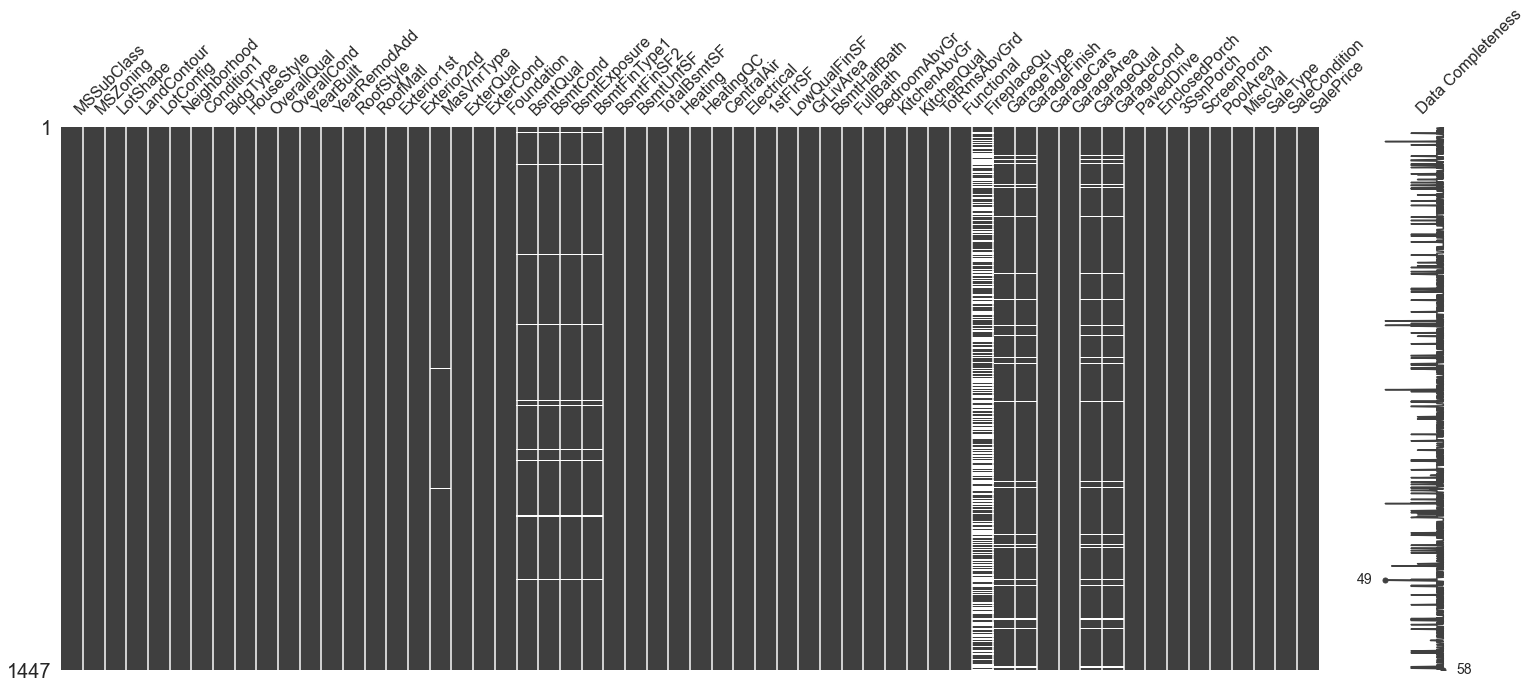

In [155]:
filtered_data = msno.nullity_filter(trainDf, filter='top', p=0.20)
msno.matrix(filtered_data, labels=True);

In [156]:
#missing data
total = trainDf.isnull().sum().sort_values(ascending=False)
percent = (trainDf.isnull().sum()/trainDf.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
Alley,1356,0.937111
Fence,1167,0.806496
FireplaceQu,690,0.476849
GarageCond,81,0.055978
GarageType,81,0.055978
GarageFinish,81,0.055978
GarageQual,81,0.055978
BsmtExposure,38,0.026261
BsmtCond,37,0.025570
BsmtQual,37,0.025570


In [82]:
filtered_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1447 entries, 0 to 1459
Data columns (total 58 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   MSSubClass     1447 non-null   int64 
 1   MSZoning       1447 non-null   object
 2   LotShape       1447 non-null   object
 3   LandContour    1447 non-null   object
 4   LotConfig      1447 non-null   object
 5   Neighborhood   1447 non-null   object
 6   Condition1     1447 non-null   object
 7   BldgType       1447 non-null   object
 8   HouseStyle     1447 non-null   object
 9   OverallQual    1447 non-null   int64 
 10  OverallCond    1447 non-null   int64 
 11  YearBuilt      1447 non-null   object
 12  YearRemodAdd   1447 non-null   object
 13  RoofStyle      1447 non-null   object
 14  RoofMatl       1447 non-null   object
 15  Exterior1st    1447 non-null   object
 16  Exterior2nd    1447 non-null   object
 17  MasVnrType     1439 non-null   object
 18  ExterQual      1447 non-null

In [157]:
# Alley: Type of alley access to property
#        Grvl	Gravel
#        Pave	Paved
#        NA 	No alley access

# Fill in NA with NoAlley in the Alley feature of the dataframe
trainDf['Alley'].fillna(value='NoAlley', inplace=True)

# Fence: Fence quality
#        GdPrv	Good Privacy
#        MnPrv	Minimum Privacy
#        GdWo	Good Wood
#        MnWw	Minimum Wood/Wire
#        NA	No Fence

# Fill in NA with NoFence in the Fence feature of the dataframe
trainDf['Fence'].fillna(value='NoFence', inplace=True)



# FireplaceQu: Fireplace quality
#        Ex	Excellent - Exceptional Masonry Fireplace
#        Gd	Good - Masonry Fireplace in main level
#        TA	Average - Prefabricated Fireplace in main living area or Masonry Fireplace in basement
#        Fa	Fair - Prefabricated Fireplace in basement
#        Po	Poor - Ben Franklin Stove
#        NA	No Fireplace

# Fill in NA with NoFireplace in the FireplaceQu feature of the dataframe
trainDf['FireplaceQu'].fillna(value='NoFireplace', inplace=True)

# GarageCond: Garage condition
#        Ex	Excellent
#        Gd	Good
#        TA	Typical/Average
#        Fa	Fair
#        Po	Poor
#        NA	No Garage

# Fill in NA with NoGarage in the GarageQual feature of the dataframe
trainDf['GarageCond'].fillna(value='NoGarage', inplace=True)

# GarageType: Garage location
#        2Types	More than one type of garage
#        Attchd	Attached to home
#        Basment	Basement Garage
#        BuiltIn	Built-In (Garage part of house - typically has room above garage)
#        CarPort	Car Port
#        Detchd	Detached from home
#        NA	No Garage

# Fill in NA with NoGarage in the GarageType feature of the dataframe
trainDf['GarageType'].fillna(value='NoGarage', inplace=True)

# GarageFinish: Interior finish of the garage
#        Fin	Finished
#        RFn	Rough Finished	
#        Unf	Unfinished
#        NA	No Garage

# Fill in NA with NoGarage in the GarageFinish feature of the dataframe
trainDf['GarageFinish'].fillna(value='NoGarage', inplace=True)

# GarageQual: Garage quality
#        Ex	Excellent
#        Gd	Good
#        TA	Typical/Average
#        Fa	Fair
#        Po	Poor
#        NA	No Garage

# Fill in NA with NoGarage in the GarageQual feature of the dataframe
trainDf['GarageQual'].fillna(value='NoGarage', inplace=True)


# BsmtExposure: Refers to walkout or garden level walls
#        Gd	Good Exposure
#        Av	Average Exposure (split levels or foyers typically score average or above)	
#        Mn	Mimimum Exposure
#        No	No Exposure
#        NA	No Basement

# Fill in NA with NoBsmt in the BsmtExposure feature of the dataframe
trainDf['BsmtExposure'].fillna(value='NoBsmt', inplace=True)

# BsmtQual: Evaluates the height of the basement
#        Ex	Excellent (100+ inches)	
#        Gd	Good (90-99 inches)
#        TA	Typical (80-89 inches)
#        Fa	Fair (70-79 inches)
#        Po	Poor (<70 inches
#        NA	No Basement

# Fill in NA with NoBsmt in the BsmtQual feature of the dataframe
trainDf['BsmtQual'].fillna(value='NoBsmt', inplace=True)

# BsmtCond: Evaluates the general condition of the basement
#        Ex	Excellent
#        Gd	Good
#        TA	Typical - slight dampness allowed
#        Fa	Fair - dampness or some cracking or settling
#        Po	Poor - Severe cracking, settling, or wetness
#        NA	No Basement

# Fill in NA with NoBsmt in the BsmtCond feature of the dataframe
trainDf['BsmtCond'].fillna(value='NoBsmt', inplace=True)


# BsmtFinType1: Rating of basement finished area
#        GLQ	Good Living Quarters
#        ALQ	Average Living Quarters
#        BLQ	Below Average Living Quarters	
#        Rec	Average Rec Room
#        LwQ	Low Quality
#        Unf	Unfinshed
#        NA	No Basement

# Fill in NA with NoBsmt in the BsmtFinType1 feature of the dataframe
trainDf['BsmtFinType1'].fillna(value='NoBsmt', inplace=True)

trainDf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1447 entries, 0 to 1446
Data columns (total 60 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   MSSubClass     1447 non-null   int64 
 1   MSZoning       1447 non-null   object
 2   Alley          1447 non-null   object
 3   LotShape       1447 non-null   object
 4   LandContour    1447 non-null   object
 5   LotConfig      1447 non-null   object
 6   Neighborhood   1447 non-null   object
 7   Condition1     1447 non-null   object
 8   BldgType       1447 non-null   object
 9   HouseStyle     1447 non-null   object
 10  OverallQual    1447 non-null   int64 
 11  OverallCond    1447 non-null   int64 
 12  YearBuilt      1447 non-null   object
 13  YearRemodAdd   1447 non-null   object
 14  RoofStyle      1447 non-null   object
 15  RoofMatl       1447 non-null   object
 16  Exterior1st    1447 non-null   object
 17  Exterior2nd    1447 non-null   object
 18  MasVnrType     1439 non-null

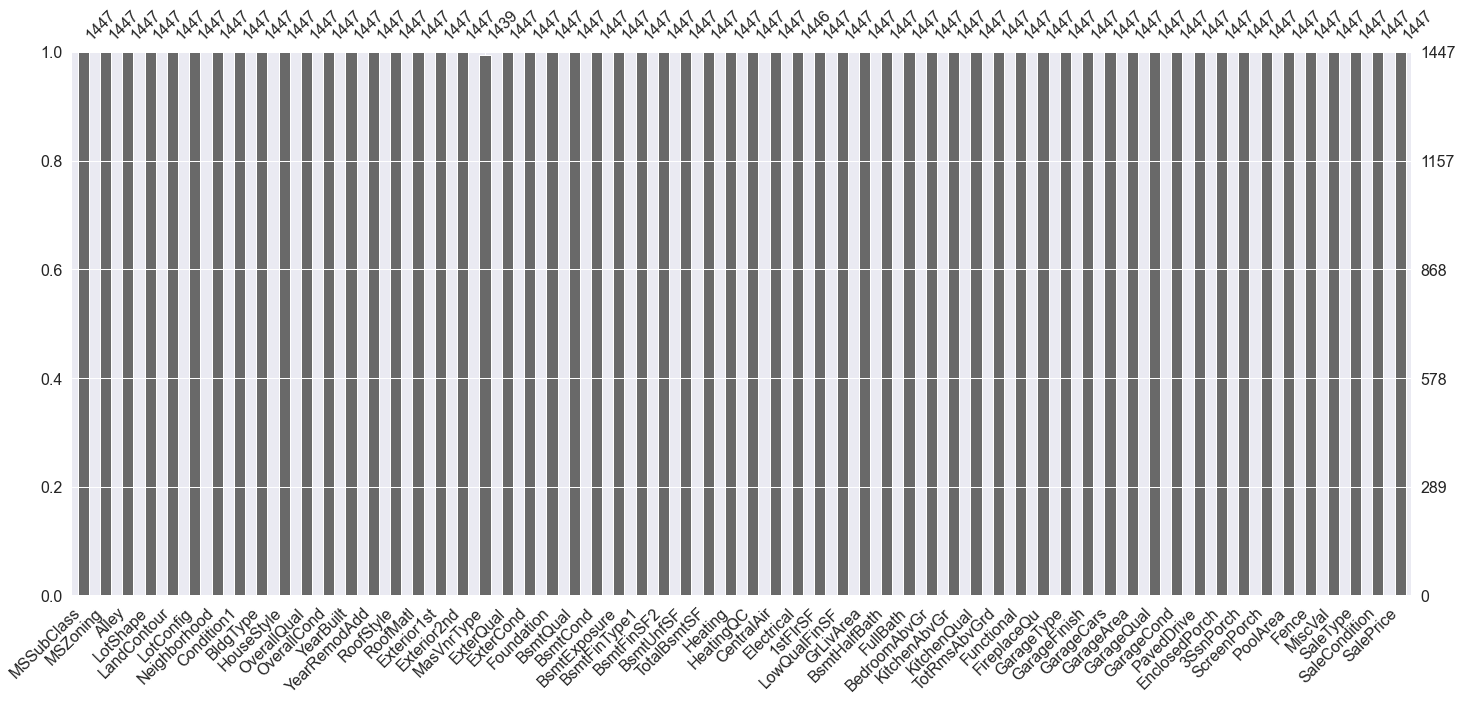

In [159]:
msno.bar(trainDf, labels=True);

In [160]:
trainDf.to_csv('House_Price_Final_Dataset.csv', index=False)

MasVnrType
None          861
BrkFace       442
Stone         121
BrkCmn         15
dtype: int64

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1447 entries, 0 to 1459
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   MasVnrType  1439 non-null   object
dtypes: object(1)
memory usage: 62.6+ KB


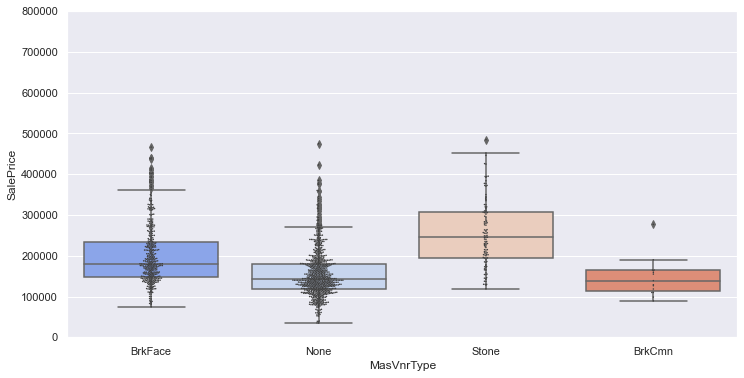

In [51]:
#box plot MasVnrType/saleprice
var = 'MasVnrType'
data = pd.concat([trainDf['SalePrice'], trainDf[var]], axis=1)
f, ax = plt.subplots(figsize=(12, 6))
fig = sns.boxplot(x=var, y="SalePrice", data=data, palette="coolwarm")
fig = sns.swarmplot(x=var, y="SalePrice", data=data, color=".25", size=1.5)
fig.axis(ymin=0, ymax=800000);

display(trainDf[[var]].value_counts())
trainDf[[var]].info()

In [ ]:
def root_mean_squared_log_error(y_valid, y_preds):
    """Calculate root mean squared error of log(y_true) and log(y_pred)"""
    if len(y_preds)!=len(y_valid): return 'error_mismatch'
    y_preds_new = [math.log(x) for x in y_preds]
    y_valid_new = [math.log(x) for x in y_valid]
    return mean_squared_error(y_valid_new, y_preds_new, squared=False)